In [2]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
import numpy as np
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
from torch.nn.functional import relu
import copy
import time
from collections import defaultdict
from torch.optim import lr_scheduler
import torch.nn.functional as F
from sklearn.metrics import precision_recall_fscore_support


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! git clone https://github.com/pdollar/coco/
%cd coco/PythonAPI
! make
! python setup.py install
%cd ../..
! rm -r coco

Cloning into 'coco'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 13.88 MiB/s, done.
Resolving deltas: 100% (576/576), done.
/content/coco/PythonAPI
python setup.py build_ext --inplace
running build_ext
Compiling pycocotools/_mask.pyx because it changed.
[1/1] Cythonizing pycocotools/_mask.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/coco/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-cpython-310
creating build/temp.linux-x86_64-cpython-310/pycocotools
x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wform

In [4]:
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2023-12-17 07:02:00--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.107.225, 3.5.9.207, 54.231.171.217, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.107.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  34.2MB/s    in 7m 14s  

2023-12-17 07:09:14 (42.5 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2023-12-17 07:09:14--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.170.187, 52.217.205.105, 16.182.35.161, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.170.187|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>

In [ ]:
!unzip \*.zip
!rm *.zip

In [6]:
path2data="./train2017"
path2json="./annotations/instances_train2017.json"

path2data_val="./val2017"
_val="./annotations/instances_val2017.json"


In [7]:
# Define the transformer
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

coco_train = datasets.CocoDetection(root = path2data,annFile = path2json,transform=transform)

# reduce train dataset
coco_train = torch.utils.data.Subset(coco_train, [i for i in range(10240)])

loading annotations into memory...
Done (t=19.91s)
creating index...
index created!


In [9]:
coco_val = datasets.CocoDetection(root = path2data_val,annFile = _val,transform=transform)
# reduce validation dataset
coco_val = torch.utils.data.Subset(coco_val, [i for i in range(2000)])

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


In [11]:
print('Number of train samples: ', len(coco_train))
print('Number of validation samples: ', len(coco_val))


Number of train samples:  10240
Number of validation samples:  2000


### find number of total object in our dataset

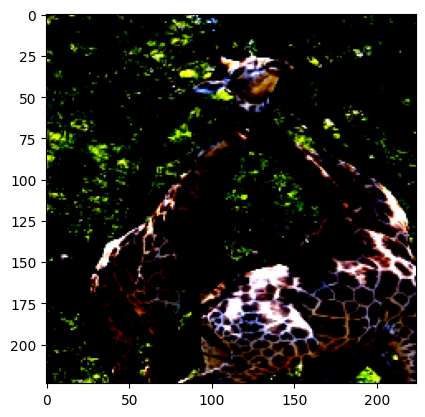

In [ ]:
img, target = coco_train[10]
plt.imshow(img.numpy().transpose(1,2,0));

### Define Dataset class

In [12]:
class CocoDataset(Dataset):
    def __init__(self, num_objects,dataset):
        self.coco_dataset = dataset
        self.num_objects = num_objects

    def convert_to_one_hot(self,numbers, size):
        one_hot_vector = np.zeros(size)
        one_hot_vector[numbers] = 1
        return torch.from_numpy(one_hot_vector)

    def __getitem__(self, index):
        """
        target  >>   a 90d multi-hot vector  [obj1 ,obj2, ... , obj90]
        obj1 = 1,  it means there is object 1 in the image.
        obj1 = 1,  it means there is not object 1 in the image.
        """
        data,target = self.coco_dataset[index]
        objects_list = [target[i]['category_id']-1 for i in range(len(target))]
        # print(objects_list)
        return data , self.convert_to_one_hot(objects_list,self.num_objects)

    def __len__(self):
        return len(self.coco_dataset)

In [13]:
# define train dataset
train_dataset = CocoDataset(90,coco_train)
# define test dataset
test_dataset = CocoDataset(90,coco_val)

b_size = 64
# Create a data loader
train_data_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=b_size, shuffle=True)

  0%|          | 0/925 [00:01<?, ?it/s]


tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)


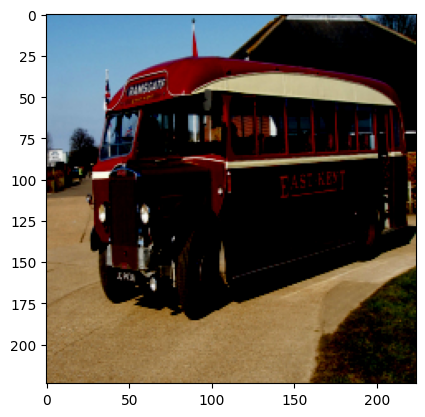

In [ ]:
for (data, targets) in tqdm(train_data_loader):
    index = 0
    plt.imshow(data[0].numpy().transpose(1, 2, 0))
    print(targets[0])
    break

## Define **Deformable Convolution** layer class

In [3]:
class DeformableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size=3, stride=1, padding=1, dilation=1,deformable_groups=1):
        super(DeformableConv2d, self).__init__()

        self.kernel_size = (kernel_size, kernel_size)
        self.stride = (stride, stride)
        self.padding = padding
        self.dilation = dilation


        self.modulator = nn.Conv2d(in_channels,deformable_groups,
            kernel_size=self.kernel_size, stride=stride, padding=self.padding,
            dilation=self.dilation, bias=False)
        
        self.offset_conv = nn.Conv2d(in_channels,deformable_groups * 2,
            kernel_size=self.kernel_size, stride=stride, padding=self.padding,
            dilation=self.dilation, bias=False)

        self.final_conv = nn.Conv2d(in_channels,out_channels,
            kernel_size=self.kernel_size, stride=stride, padding=self.padding,
            dilation=self.dilation, bias=False)

    def deformed_feature(self, x):
        N, C, H, W = x.shape        
        grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W))
        grid_y = grid_y.to(device=x.device)
        grid_x = grid_x.to(device=x.device)
        # create offset 
        offset = self.offset_conv(x)
        grid_y = grid_y.view(1, H, W) + offset[:, 0, :, :]  # y0 = y0 + Δy
        grid_x = grid_x.view(1, H, W) + offset[:, 1, :, :]  # x0 = x0 + Δx

        grid_y = 2 * grid_y / (H - 1) - 1
        grid_x = 2 * grid_x / (W - 1) - 1
        # Interpolate features 
        grid = torch.stack((grid_x, grid_y), dim=-1)
        features = nn.functional.grid_sample(x, grid, mode='bilinear', align_corners=False)
        # create mask
        mask = 2 * torch.sigmoid(self.modulator(x))

        return features * mask

    def forward(self, x):
        deformed_features = self.deformed_feature(x)
        features = self.final_conv(deformed_features)
        return features

### Test the `DofromConv2d` layer:

In [4]:
deformable_conv = DeformableConv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, deformable_groups=1)
test = torch.randn(6, 32, 224, 224)  # (#samples, #in channels, # heights, # width)
out = deformable_conv(test)

print(out.shape)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([6, 64, 224, 224])


----

## Implement **ObjectDetector** class

In [16]:
class ObjectDetector(nn.Module):
    def __init__(self, n_class, deformable=False):
        super().__init__()
        conv = nn.Conv2d if deformable==False else DeformableConv2d
        '''
        Each blockو consists of two convolutional layers followed
        by a max-pooling layer, with the exception of the last block which does not
        include a max-pooling layer.
        '''
        # input: 224x224x3"
        self.e11 = conv(3, 64, kernel_size=3, padding=1)
        self.e12 = conv(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = conv(64, 128, kernel_size=3, padding=1)
        self.e22 = conv(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = conv(128, 256, kernel_size=3, padding=1)
        self.e32 = conv(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = conv(256, 512, kernel_size=3, padding=1)
        self.e42 = conv(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = conv(512, 1024, kernel_size=3, padding=1)
        self.e52 = conv(1024, 1024, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(1024, n_class, kernel_size=1)

        self.fc_layers = nn.Sequential(
            nn.Linear(17640, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, n_class))

        self.BN = nn.BatchNorm1d(n_class)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Conv layers
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Output layer
        out = self.outconv(xe52)
        out = self.fc_layers(out.view(out.shape[0],-1))
        out= self.BN(out)

        return self.sigmoid(out)

In [17]:
def get_data_loaders(train_data_loader, test_data_loader):
    dataloaders = {
        'train': train_data_loader,
        'val': test_data_loader}
    return dataloaders

def calc_loss(pred, target,metrics, criterion):
    loss = criterion(pred, target)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    # print(loss.data.cpu().numpy(),'ppp')
    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
    print("{}: {}".format(phase, ", ".join(outputs)))

In [18]:
def train_model(model, optimizer, scheduler, num_epochs=20):
    output_metrics = {'f1':{'train':[],
                            'val':[]},
                      'precision':{'train':[],
                                    'val':[]},
                      'recall':{'train':[],
                                'val':[]},
                      'loss':{'train':[],
                              'val':[]}
                      }

    all_metrics = ['precision','recall','f1','loss']


    dataloaders = get_data_loaders(train_data_loader,test_data_loader)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    epoch_loss = 0
    losses = []
    criterion = torch.nn.BCELoss()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 20)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            all_predicted = []
            all_targets = []
            for index,(inputs, labels) in enumerate(tqdm(dataloaders[phase])):
                inputs = inputs.to(device).float()
                labels = labels.to(device).float()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics, criterion)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                predicted = (outputs > 0.5).float()
                all_predicted.extend(predicted.cpu().numpy().flatten())
                all_targets.extend(labels.cpu().numpy().flatten())

                epoch_samples += inputs.size(0)

            temp = [0,0,0,0]
            temp[0], temp[1], temp[2], _ = precision_recall_fscore_support(all_targets, all_predicted, average='binary')
            temp[3] = metrics['loss'] / epoch_samples
            for index,metric in enumerate(all_metrics):
              output_metrics[metric][phase].append(temp[index])

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

        # save the checkpoint
        checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }
        torch.save(checkpoint, f'/content/drive/My Drive/DEEP/HW3/Q2/checkpoints/model_checkpoint{epoch}.pth')

        # Save the dictionary to a file
        with open('/content/drive/My Drive/DEEP/dictionary_conv_deform.pickle', 'wb') as file:
            pickle.dump(output_metrics, file)

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,output_metrics

In [19]:
num_class = 90
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ObjectDetector(num_class,True).to(device)

optimizer_ft = torch.optim.Adam(model.parameters(), lr=1e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

ObjectDetector_model_deform,output_metrics_deform_cov = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=50)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 0/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:20<00:00,  2.01s/it]


train: loss: 12.659746


100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


val: loss: 13.286156
saving best model
5m 53s
Epoch 1/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:02<00:00,  1.89s/it]


train: loss: 12.498481


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


val: loss: 12.741212
saving best model
5m 31s
Epoch 2/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:02<00:00,  1.89s/it]


train: loss: 12.366089


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


val: loss: 12.683113
saving best model
5m 30s
Epoch 3/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:02<00:00,  1.89s/it]


train: loss: 12.261192


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


val: loss: 12.615886
saving best model
5m 30s
Epoch 4/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:01<00:00,  1.89s/it]


train: loss: 12.179710


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


val: loss: 12.514796
saving best model
5m 29s
Epoch 5/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:01<00:00,  1.88s/it]


train: loss: 12.096168


100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


val: loss: 12.459594
saving best model
5m 32s
Epoch 6/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:02<00:00,  1.89s/it]


train: loss: 12.034961


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


val: loss: 12.367688
saving best model
5m 30s
Epoch 7/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:03<00:00,  1.89s/it]


train: loss: 11.976333


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


val: loss: 12.394342
5m 31s
Epoch 8/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:02<00:00,  1.89s/it]


train: loss: 11.912009


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


val: loss: 12.293275
saving best model
5m 31s
Epoch 9/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:03<00:00,  1.90s/it]


train: loss: 11.862689


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


val: loss: 12.169488
saving best model
5m 31s
Epoch 10/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:03<00:00,  1.90s/it]


train: loss: 11.809383


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


val: loss: 12.222770
5m 31s
Epoch 11/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:02<00:00,  1.89s/it]


train: loss: 11.750817


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


val: loss: 12.165650
saving best model
5m 30s
Epoch 12/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:03<00:00,  1.90s/it]


train: loss: 11.699660


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


val: loss: 12.135320
saving best model
5m 32s
Epoch 13/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:01<00:00,  1.88s/it]


train: loss: 11.643873


100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


val: loss: 12.106657
saving best model
5m 31s
Epoch 14/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:02<00:00,  1.89s/it]


train: loss: 11.588677


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


val: loss: 12.082300
saving best model
5m 30s
Epoch 15/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:02<00:00,  1.89s/it]


train: loss: 11.518997


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


val: loss: 12.066819
saving best model
5m 30s
Epoch 16/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:02<00:00,  1.89s/it]


train: loss: 11.447568


100%|██████████| 32/32 [00:26<00:00,  1.23it/s]


val: loss: 12.068525
5m 31s
Epoch 17/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:04<00:00,  1.90s/it]


train: loss: 11.367355


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


val: loss: 12.122189
5m 33s
Epoch 18/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:03<00:00,  1.89s/it]


train: loss: 11.286039


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


val: loss: 12.106544
5m 31s
Epoch 19/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:03<00:00,  1.90s/it]


train: loss: 11.190346


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


val: loss: 12.103490
5m 31s
Epoch 20/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:03<00:00,  1.89s/it]


train: loss: 11.122316


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


val: loss: 12.118735
5m 31s
Epoch 21/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:03<00:00,  1.90s/it]


train: loss: 11.046775


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


val: loss: 12.167153
5m 33s
Epoch 22/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:01<00:00,  1.88s/it]


train: loss: 10.972861


100%|██████████| 32/32 [00:25<00:00,  1.23it/s]


val: loss: 12.140763
5m 29s
Epoch 23/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:04<00:00,  1.90s/it]


train: loss: 10.912205


100%|██████████| 32/32 [00:26<00:00,  1.19it/s]


val: loss: 12.171437
5m 32s
Epoch 24/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:04<00:00,  1.90s/it]


train: loss: 10.865225


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


val: loss: 12.193529
5m 32s
Epoch 25/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:01<00:00,  1.89s/it]


train: loss: 10.823757


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


val: loss: 12.220775
5m 29s
Epoch 26/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:03<00:00,  1.90s/it]


train: loss: 10.783514


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


val: loss: 12.207347
5m 32s
Epoch 27/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:01<00:00,  1.89s/it]


train: loss: 10.741004


100%|██████████| 32/32 [00:26<00:00,  1.23it/s]


val: loss: 12.245157
5m 29s
Epoch 28/49
--------------------
LR 0.001


100%|██████████| 160/160 [05:01<00:00,  1.89s/it]


train: loss: 10.706290


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


val: loss: 12.232350
5m 30s
Epoch 29/49
--------------------
LR 0.0001


100%|██████████| 160/160 [05:02<00:00,  1.89s/it]


train: loss: 10.661602


100%|██████████| 32/32 [00:25<00:00,  1.23it/s]


val: loss: 12.262089
5m 30s
Epoch 30/49
--------------------
LR 0.0001


100%|██████████| 160/160 [05:01<00:00,  1.89s/it]


train: loss: 10.643214


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


val: loss: 12.266813
5m 29s
Epoch 31/49
--------------------
LR 0.0001


100%|██████████| 160/160 [05:03<00:00,  1.89s/it]


train: loss: 10.633055


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


val: loss: 12.282963
5m 31s
Epoch 32/49
--------------------
LR 0.0001


100%|██████████| 160/160 [05:02<00:00,  1.89s/it]


train: loss: 10.628025


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


val: loss: 12.287301
5m 30s
Epoch 33/49
--------------------
LR 0.0001


100%|██████████| 160/160 [05:03<00:00,  1.90s/it]


train: loss: 10.618376


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


val: loss: 12.292230
5m 31s
Epoch 34/49
--------------------
LR 0.0001


100%|██████████| 160/160 [05:04<00:00,  1.90s/it]


train: loss: 10.612285


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


val: loss: 12.299742
5m 32s
Epoch 35/49
--------------------
LR 0.0001


100%|██████████| 160/160 [05:00<00:00,  1.88s/it]


train: loss: 10.606062


100%|██████████| 32/32 [00:26<00:00,  1.23it/s]


val: loss: 12.308292
5m 29s
Epoch 36/49
--------------------
LR 0.0001


100%|██████████| 160/160 [05:04<00:00,  1.91s/it]


train: loss: 10.600947


100%|██████████| 32/32 [00:33<00:00,  1.03s/it]


val: loss: 12.305613
5m 40s
Epoch 37/49
--------------------
LR 0.0001


100%|██████████| 160/160 [05:04<00:00,  1.91s/it]


train: loss: 10.594218


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


val: loss: 12.315160
5m 33s
Epoch 38/49
--------------------
LR 0.0001


100%|██████████| 160/160 [05:02<00:00,  1.89s/it]


train: loss: 10.589910


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


val: loss: 12.320227
5m 30s
Epoch 39/49
--------------------
LR 0.0001


100%|██████████| 160/160 [05:01<00:00,  1.88s/it]


train: loss: 10.583662


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


val: loss: 12.325678
5m 29s
Epoch 40/49
--------------------
LR 0.0001


100%|██████████| 160/160 [05:02<00:00,  1.89s/it]


train: loss: 10.579728


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


val: loss: 12.332844
5m 30s
Epoch 41/49
--------------------
LR 0.0001


100%|██████████| 160/160 [05:02<00:00,  1.89s/it]


train: loss: 10.572421


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


val: loss: 12.334958
5m 30s
Epoch 42/49
--------------------
LR 0.0001


100%|██████████| 160/160 [05:02<00:00,  1.89s/it]


train: loss: 10.566454


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


val: loss: 12.342169
5m 31s
Epoch 43/49
--------------------
LR 0.0001


100%|██████████| 160/160 [05:01<00:00,  1.88s/it]


train: loss: 10.561203


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


val: loss: 12.339543
5m 29s
Epoch 44/49
--------------------
LR 0.0001


100%|██████████| 160/160 [05:04<00:00,  1.90s/it]


train: loss: 10.556377


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


val: loss: 12.357043
5m 32s
Epoch 45/49
--------------------
LR 0.0001


100%|██████████| 160/160 [05:03<00:00,  1.90s/it]


train: loss: 10.552852


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


val: loss: 12.355315
5m 31s
Epoch 46/49
--------------------
LR 0.0001


100%|██████████| 160/160 [05:01<00:00,  1.89s/it]


train: loss: 10.547666


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


val: loss: 12.360708
5m 30s
Epoch 47/49
--------------------
LR 0.0001


100%|██████████| 160/160 [05:02<00:00,  1.89s/it]


train: loss: 10.542082


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


val: loss: 12.363745
5m 31s
Epoch 48/49
--------------------
LR 0.0001


100%|██████████| 160/160 [05:02<00:00,  1.89s/it]


train: loss: 10.535386


100%|██████████| 32/32 [00:28<00:00,  1.14it/s]


val: loss: 12.371010
5m 33s
Epoch 49/49
--------------------
LR 0.0001


100%|██████████| 160/160 [05:06<00:00,  1.92s/it]


train: loss: 10.533096


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


val: loss: 12.366680
5m 34s
Best val loss: 12.066819
